1. Difficulty evaluation using trajectory rewards

Visualization of the state

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


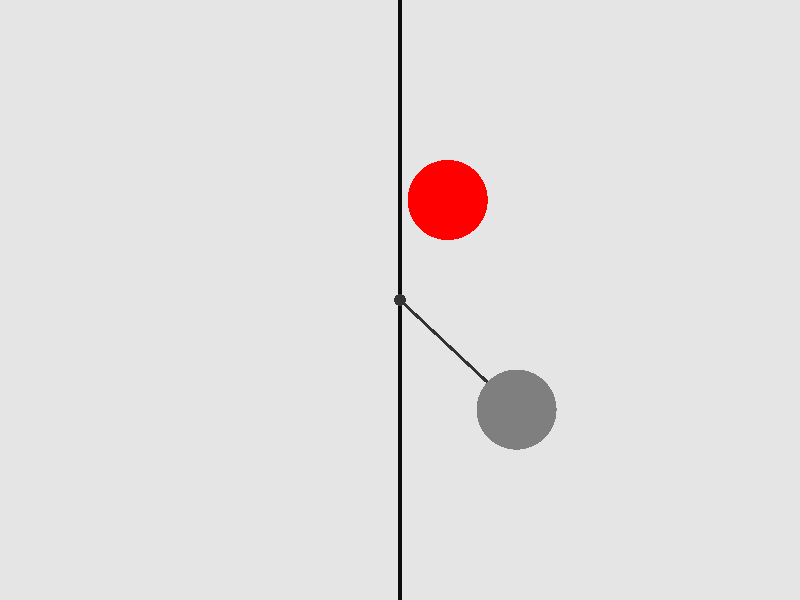

In [31]:
%load_ext autoreload
%autoreload 2

from copy import copy

import matplotlib.pyplot as plt
import torch
from IPython.core.display import clear_output
from torch.nn import LeakyReLU

from framework import TrajectoryRewardsEvaluator, QEvaluator, DQNAgent
from pendulum import PendulumEnvironment, PendulumRenderer, PendulumState
from pendulum.heuristic import *
from shared_parameters import *
from utils import save, load
from utils import mean, running_average

env = PendulumEnvironment(*pendulum_env_args, time_scale=5, step_reward=1.0, action_reward=-0.1, death_reward=-100.0)
renderer = PendulumRenderer(bob_radius, connector_length, enemy_radius, enemy_y)

renderer.render(env.get_starting_state(), to_image=True)

### Note for all difficulty estimators

Currently, we have a small embedding space (just one dimension),
thus it's possible to pre-evaluate it directly, and then use the
cached difficulty evaluations.

Within the bigger space it's not possible, and we will have to
come up with some clever way of caching, where we don't store the
evaluation for every point space, but neither perform an evaluation
each time for each point.

### Direct difficulty estimation

In [3]:
oracle = HeuristicPendulumEvaluator(connector_length, max_angle, enemy_radius, bob_radius)
state = env.get_starting_state()
difficulty = oracle(state)

print(state.to_string())
print(f"difficulty: {difficulty.item():.3f}")

Pendulum(angle: 0.10, angular_speed: -0.05, vertical_position: 0.00, enemies: -0.17)
difficulty: 0.543


### Difficulty estimation using trajectory rewards

In [4]:
skills = [1.0, 0.5, 0.0]
weights = [0.5, 0.25, 0.25]
agents = [HeuristicPendulumActor(enemy_radius, bob_radius, connector_length, enemy_y, skill=skill) for skill in skills]
oracle = TrajectoryRewardsEvaluator(env, agents, weights, num_evaluations=10, max_trajectory_length=20)

states = torch.vstack([env.get_starting_state() for _ in range(10)])
oracle.evaluate(states)

tensor([0.8444, 0.8151, 0.5607, 0.1965, 0.1485, 0.9291, 0.4836, 0.8111, 0.1470,
        0.6893])

### Difficulty estimation using Q-values

1. Train agents, save at time steps
2. Use them in QEvaluator

In [35]:
# Try to load saved agents
agents = load("./saved_data/saved_agents.pt", none_on_error=True)
print(f"Loaded: {agents}")

agent = DQNAgent(PendulumState.get_size(1), action_size=2, hidden=[8, 8], activation=LeakyReLU())
if agents is None:
    agents = []
else:
    # Load the latest agent
    for p1, pt1, p2, pt2 in zip(agents[-1].nn.parameters(), agents[-1].target_nn.parameters(),
                                agent.nn.parameters(), agent.target_nn.parameters()):
        p2.data = p1.data
        pt2.data = pt1.data

total_rewards = []

Loaded: [<framework.agents.dqn_agent.DQNAgent object at 0x0000021051B81130>]


Run next cell to train the agent until you're satisfied. Run the cell above it to save the agent

loss: 90.6985855102539. Mean total reward: -2.816200000000006


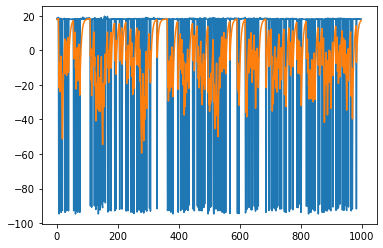

In [232]:
# Train the agent for N iterations
agent.eval = False
loss = agent.train(env, epochs=100, max_trajectory_length=20)
agent.eval = True

for _ in range(10):
    state = env.get_starting_state()
    total_reward = 0.0

    for _ in range(20):
        action = agent.get_action(state)
        state, reward, done = env.transition(state, action)
        total_reward += reward
        if done:
            break

    total_rewards.append(total_reward)
    if len(total_rewards) > 1000:
        total_rewards.pop(0)

clear_output(wait=True)
print(f"loss: {loss}. Mean total reward: {mean(total_rewards)}")
plt.plot(total_rewards)
plt.plot(running_average(total_rewards))
plt.show()

In [233]:
# Use this to append an agent
agents.append(copy(agent))
print(f"Total of: {len(agents)} agents")
save(agents, "./saved_data/saved_agents.pt")

Total of: 4 agents


Now we have our agents, let's run the evaluator

In [235]:
for agent in agents:
    agent.eval = True

weights = [0.1, 0.2, 0.3, 0.4]
oracle = QEvaluator(env, agents, weights, num_evaluations=1, max_trajectory_length=20)
oracle(env.get_starting_state())

tensor(0.2722)

### Evaluators comparison

Difficulty evaluation of the same random state:
State: tensor([-0.1608,  0.0500,  0.0000, -0.2725])

Heuristic: 0.3817
Trajectory Rewards: 0.8021
Q-Evaluator: 0.1364

Difficulty of several states:
H: tensor([0.6527, 0.3144, 0.6527, 0.1533, 0.0661])
R: tensor([0.9274, 0.2673, 0.9166, 0.2216, 0.0765])
Q: tensor([0.0390, 0.0174, 0.0563, 0.0161, 0.0162])

Difficulty of the whole range
Evaluating 1/26
Evaluating 2/26
Evaluating 3/26
Evaluating 4/26
Evaluating 5/26
Evaluating 6/26
Evaluating 7/26
Evaluating 8/26
Evaluating 9/26
Evaluating 10/26
Evaluating 11/26
Evaluating 12/26
Evaluating 13/26
Evaluating 14/26
Evaluating 15/26
Evaluating 16/26
Evaluating 17/26
Evaluating 18/26
Evaluating 19/26
Evaluating 20/26
Evaluating 21/26
Evaluating 22/26
Evaluating 23/26
Evaluating 24/26
Evaluating 25/26
Evaluating 26/26
[tensor(0.2867), tensor(47.5700), tensor(53.6050), tensor(60.8800), tensor(53.8633), tensor(64.9533), tensor(66.9417), tensor(68.5900), tensor(72.1833), tensor(68.5483), tensor(66.951

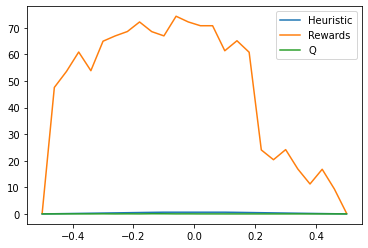

In [272]:
# Heuristic evaluator
oracle_h = HeuristicPendulumEvaluator(connector_length, max_angle, enemy_radius, bob_radius)

# Trajectory rewards evaluator
skills = [1.0, 0.5, 0.0]
weights = [0.5, 0.25, 0.25]
agents = [HeuristicPendulumActor(enemy_radius, bob_radius, connector_length, enemy_y, skill=skill) for skill in skills]
oracle_r = TrajectoryRewardsEvaluator(env, agents, weights, num_evaluations=10, max_trajectory_length=20)

# Q-Evaluator
agents = load("./saved_data/saved_agents.pt")
for agent in agents:
    agent.eval = True

weights = [0.1, 0.2, 0.3, 0.4]
oracle_q = QEvaluator(env, agents, weights, num_evaluations=1, max_trajectory_length=20)

print("Difficulty evaluation of the same random state:")

state = env.get_starting_state()
print(f"State: {state}")
print()

print(f"Heuristic: {oracle_h(state).item():.4f}")
print(f"Trajectory Rewards: {oracle_r(state).item():.4f}")
print(f"Q-Evaluator: {oracle_q(state).item():.4f}")

print()
print("Difficulty of several states:")

states = torch.vstack([env.get_starting_state() for _ in range(5)])
print(f"H: {oracle_h(states)}")
print(f"R: {oracle_r(states)}")
print(f"Q: {oracle_q(states)}")

print()
print("Difficulty of the whole range")

states = []
evaluations_h = []
evaluations_r = []
evaluations_q = []
state = env.get_starting_state()
num_states = 26
for i, x in enumerate(torch.linspace(enemy_x_min, enemy_x_max, num_states)):
    print(f"Evaluating {i + 1}/{num_states}")
    s = state.clone()
    s.enemy_x = x
    states.append(x)

    evaluations_h.append(oracle_h(s))
    evaluations_r.append(oracle_r(s))
    evaluations_q.append(oracle_q(s))

[tensor(0.2867), tensor(47.5700), tensor(53.6050), tensor(60.8800), tensor(53.8633), tensor(64.9533), tensor(66.9417), tensor(68.5900), tensor(72.1833), tensor(68.5483), tensor(66.9517), tensor(74.3350), tensor(72.1950), tensor(70.7667), tensor(70.7683), tensor(61.3567), tensor(65.1217), tensor(60.8033), tensor(24.0633), tensor(20.3883), tensor(24.1850), tensor(16.8900), tensor(11.2667), tensor(16.7983), tensor(9.3867), tensor(0.2687)]


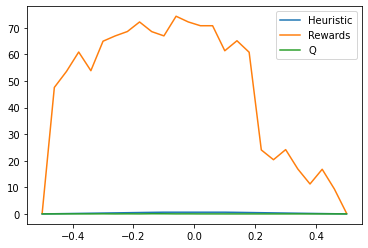

In [275]:
print(evaluations_r)

plt.plot(states, evaluations_h)
plt.plot(states, evaluations_r)
plt.plot(states, evaluations_q)
plt.legend(["Heuristic", "Rewards", "Q"])
plt.show()